In [1]:
#AN IDEA IS TO RUN WITH AND WITHOUT TURNING EVERYTHING TO THRESHOLD-LIKE VARIABLES

In [2]:
import os
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.font_manager
import seaborn as sn
from scipy.stats import zscore
import numpy as np
#matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
sn.set_style("white")

from scipy.spatial import cKDTree

csfont = {'fontname':'Adobe Garamond Pro','fontsize':30}
hfont = {'fontname':'Adobe Garamond Pro','fontsize':12}

In [3]:
dd = pd.read_csv(r"G:\Mi unidad\walknet_datalake\extractions\pois_other_300.csv")

In [4]:
df = pd.read_csv(r"G:\Mi unidad\walknet_datalake\sources\edm2018\level1\level1_edm2018.csv",sep=",")
print(len(df))
df = df[df['ZT1259'].str.startswith(("005", "006", "007", "022", "026", "045", "049", "058", "065", "073", "074", "080", "084", "092", "104", "106", "113", "115", "127", "130", "134", "148", "167", "176", "177", "181", "184", "079","123","903"))]
df['CODMUNI'] = df['CODMUNI'].astype(str).str.zfill(3)
df['edge_id'] = df['VORIZT1259']+"|"+df['VDESZT1259']
relations = df['edge_id'].unique()
df.drop_duplicates(subset=['ID_HOGAR','ID_IND','ID_VIAJE'],inplace=True)
df = df[df['VDES']!='Casa']
df = df[df['VORI']=='Casa']
df = df[df['C8ACTIV']!='Otra situación']
df = df[df['CPMR'] == 'No']
df = df[df['EMODO'].isin(['Andando/ pie','Coche pasajero','Coche conductor'])]
df = df[~df['VFRECUENCIA'].isin(['Alguna vez','Es la primera vez que hago el viaje'])]
df = df[df['MOTIVO_PRIORITARIO'].isin(['Compras','Estudio', 'Ocio', 'Deporte/ dar un paseo','Acompañamiento a otra persona','Médico'])]
df = df[df['DISTANCIA_VIAJE'] < 900]

266994


In [5]:
df['VORIHORAINI'] = df['VORIHORAINI'].astype(int).astype(str).str.zfill(4).str[:2] + ":" + df['VORIHORAINI'].astype(int).astype(str).str.zfill(4).str[2:]
df['VDESHORAFIN'] = df['VDESHORAFIN'].astype(int).astype(str).str.zfill(4).str[:2] + ":" + df['VDESHORAFIN'].astype(int).astype(str).str.zfill(4).str[2:]

In [6]:
df = df[~df['VDESHORAFIN'].str.startswith(("25","26"))]
df = df[~df['VORIHORAINI'].str.startswith(("25","26"))]

df.loc[df['VORIHORAINI'].str.startswith("24"),'VORIHORAINI'] = df[df['VORIHORAINI'].str.startswith("24")]['VORIHORAINI'].str.replace("24:","00:")
df.loc[df['VDESHORAFIN'].str.startswith("24"),'VDESHORAFIN'] = df[df['VDESHORAFIN'].str.startswith("24")]['VDESHORAFIN'].str.replace("24:","00:")

df['VDESHORAFIN'] = pd.to_datetime(df['VDESHORAFIN'], format= '%H:%M' )
df['VORIHORAINI'] = pd.to_datetime(df['VORIHORAINI'], format= '%H:%M' )

In [7]:
df['DURACION_VIAJE'] = ((df['VDESHORAFIN'] - df['VORIHORAINI']).dt.seconds)/60

df['VELOCIDAD_VIAJE'] = df['DISTANCIA_VIAJE']/(df['DURACION_VIAJE']/60)

df['DURACION_VIAJE'].fillna(0,inplace=True)
df['VELOCIDAD_VIAJE'].fillna(0,inplace=True)

C:\Users\katul\AppData\Local\Temp\ipykernel_9448\1053556119.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DURACION_VIAJE'].fillna(0,inplace=True)
C:\Users\katul\AppData\Local\Temp\ipykernel_9448\1053556119.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

In [8]:
df['VDESHORAFIN'] = df['VDESHORAFIN'].dt.hour
df['VORIHORAINI'] = df['VORIHORAINI'].dt.hour

In [9]:
categorical = {
    'C2SEXO':('Gender',{'Hombre':'Male','Mujer':'Female'},(0,0)),
    'C4NAC':('Foreign',{'No':'No','Si':'Yes'},(0,1)),
    'CPMR':('PRM',{'No':'No','Si':'Yes'},(1,0)),
    'C13TARJETA':('TravelCard',{'Tarjeta de Transporte Público TTP':"Yes", 'Ninguna':"No", 'Ambas tarjetas':"Yes",'Tarjeta MULTI':"Yes"},(1,1)),
    'VVEHICULO':('HasVehicle',{'Si':'Yes','No':'No'},(2,0)),
    'C6CARNE':('HasLicense',{'No tiene':"No", 'Carné de coche (B) o superior  (C, D ó E)':"Yes",'Carné de moto y coche':"Yes", 'Carné de moto A1/A2':"Yes", 'Sólo licencia de ciclomotor':"Yes"},(2,1)),
    'VFRECUENCIA':('Frequency',{'A diario, de lunes a viernes':"Daily",'Entre 2 y 4 días laborables por semana':"Frequently",'Es la primera vez que hago el viaje':"0",'Menos de dos días laborables por semana':"Less Frequently", 'Alguna vez':"Sometimes"},(3,0)),
    'DIASEM':('DayOfWeek',{"Lunes":"Monday","Martes":"Tuesday","Miércoles":"Wednesday","Jueves":"Thursday"},(3,1)),
    'C7ESTUD':('EducationLevel',{'Primera etapa de Educación Secundaria y similar':"Second - A",'Educación Primaria':"First",'Segunda etapa de Educación Secundaria y similar':"Second - B",'Menos que Primaria':"No",'Enseñanzas de Formación Profesional de grado superior y equivalentes':"Third",'Educación postsecundaria no superior':"Second - B", 'Grados universitarios/licenciaturas/másteres y enseñanzas de doctorado':"Third"},(4,0)),
    'C8ACTIV':('Activity',{'Parado, ha trabajado antes':"Unemployed", 'Jubilado / Retirado/ Pensionista':"Retired",'Estudiante':"Student", 'Trabaja':"Worker", 'Trabaja y estudia':"Worker",'Cuidado de familiares':"Caretaker", 'Trabajo doméstico no remunerado':"Caretaker", 'Parado, busca primer trabajo':"Unemployed"},(4,1)),
    'VNOPRIVADO':("NoPrivate",{'No me gusta el coche':"Dislike", 'Más incómodo':"Less Convenient",'Evitar el atasco':"Congestion",'Contamino menos':"Other",'Dificultad de aparcamiento':"Hard to Park",'Otros':"Other",'Tardo más':"Takes Longer",'Es más caro':"Other"},(5,0)),
    'VNOPUBLICO':("NoPublic",{'No hay servicio público':"Bad Service",'Es más caro':"Other",'Tardo más':"Takes Longer",'El destino está muy cerca':"Very Close",'Otros':"Other",'Necesito mi vehículo para trabajar o gestión personal':"Other",'Mala combinación del tte.público':"Bad Service",'Prefiero ir andando / en bicicleta':"Prefer Active Modes",'Mi situación personal condiciona esta elección modal':"Bad Service",'Más incómodo':"Less Convenient", 'Por desconocimiento/falta de información':"Other",'No me gusta el tte. público':"Other"},(5,1)),
    "MOTIVO_PRIORITARIO":("TripPurpose",{'Compras':"Shopping",'Ocio':"Leisure",'Estudio':"Study",'Trabajo':"Work",'Deporte/ dar un paseo':"Sport / Stroll",'Otro domicilio':"Other",'Asunto personal':"Other",'Acompañamiento a otra persona':"Care",'Médico':"Care",'Gestión de trabajo':"Work",'Otros':"Other"},(6,0)),
    "MODO_PRIORITARIO":("TransportMode",{'Coche conductor particular' :"Motor - Personal",'Coche pasajero particular':"Motor - Personal",'Moto/ciclomotor particular':"Motor - Personal",'Andando/pie' : "Walking",'Autobus urbano Madrid EMT':"Bus",'Autobus interurbano':"Bus",'Autobus discrecional':"Bus",'Autobus de largo recorrido':"Bus",'Autobus urbano otro municipio':"Bus",'Otros':"Other",'Metro':"Train",'Renfe Cercanías':"Train",'Resto renfe':"Train",'Metro ligero/tranvía':"Train", 'Coche conductor empresa' : "Motor - Shared",'Coche pasajero empresa': "Motor - Shared",'Taxi':"Motor - Shared",'Coche pasajero alquiler con conductor': "Motor - Shared",'Coche conductor alquiler sin conductor': "Motor - Shared",'Moto/ciclomotor empresa': "Motor - Shared",'Moto/ciclomotor publica': "Motor - Shared",'Bicicleta particular':"Cycling",'Bicicleta publica':"Cycling",'Bicicleta empresa':"Cycling"},(6,1))
    }

for c,i in categorical.items():

    df[c] = df[c].map(i[1])
    df.rename(columns={c:i[0]},inplace=True)

In [10]:
df = df[df['VELOCIDAD_VIAJE'] < 80]

df = df[df['DURACION_VIAJE'] < 300]
df = df[df['DURACION_VIAJE'] >= 0]

df = df[df['N_VIAJES_POR_HOGAR'] < 20]

df = df[df['DISTANCIA_VIAJE'] < 20]


In [11]:
df.rename(columns = {'DISTANCIA_VIAJE':'TripDistance'},inplace=True)

In [12]:
continuous = {
    'EDAD_FIN':('Age',(0,0)),
    'N_MIEMBROS_POR_HOGAR':('HouseholdSize',(0,1)),
    'N_VIAJES_POR_HOGAR':('TripsHousehold',(1,0)),
    'N_ETAPAS_POR_VIAJE':('TripStages',(1,1)),
    'VORIHORAINI':('StartTime',(2,0)),
    'VDESHORAFIN':('EndTime',(2,1)),
    'DURACION_VIAJE':('TripDuration',(3,0)),
    'VELOCIDAD_VIAJE':('TripSpeed',(3,1))
    }

for c,i in continuous.items():

    df.rename(columns={c:i[0]},inplace=True)
    df[i[0]] = df[i[0]].astype(float)



In [13]:
df.loc[df['Age']<5,'Age Status'] = "Less than 5"
df.loc[(df['Age']>=5) & (df['Age']<12),'Age Status'] = "Ages 6-12"
df.loc[(df['Age']>=12) & (df['Age']<18),'Age Status'] = "Ages 13-18"
df.loc[(df['Age']>=18) & (df['Age']<40),'Age Status'] = "Ages 19-40"
df.loc[(df['Age']>=40) & (df['Age']<65),'Age Status'] = "Ages 41-65"
df.loc[df['Age']>=65,'Age Status'] = "More than 65"

In [14]:

hd = {}
h15 = {}
h30 = {}
for h in list(df['ID_HOGAR'].unique()):
    dist = list(df[df['ID_HOGAR'] == h]['TripDuration'].values)
    
    if all(di < 30 for di in dist): h30.update({h:1})
    else: h30.update({h:0})
    
    if all(di < 15 for di in dist): h15.update({h:1})
    else: h15.update({h:0})

    hd.update({h:'Other'})
    d = df[df['ID_HOGAR'] == h][['ID_IND','Age','Age Status','HouseholdSize','Activity']].drop_duplicates(subset='ID_IND')
    if d['HouseholdSize'].values[0] == 1:
        if d['Activity'].values[0] == 'Retired': hd.update({h:'Retirees'})
        elif d['Activity'].values[0] == 'Student': hd.update({h:'Students (age 19+)'})
        elif d['Activity'].values[0] in ['Worker']: hd.update({h:'Full-Time Workers'})
        else: hd.update({h:'Other'})
    else:
        if any(act in ['Retired'] for act in d['Activity'].values): hd.update({h:'Retirees'})
        if any(act in ['Worker'] for act in d['Activity'].values): hd.update({h:'Full-Time Workers'})
        if any(age == "Ages 13-18" for age in d['Age Status'].values): hd.update({h:'Students (Age 13–18)'})
        if any(age == "Ages 6-12" for age in d['Age Status'].values): hd.update({h:'Students (Age 6–12)'})
        if any(age == "Less than 5" for age in d['Age Status'].values): hd.update({h:'Children'})
        
df['HouseholdStructure'] = df['ID_HOGAR'].map(hd)



In [15]:
df['Trip15'] = ""
df.loc[df['TripDuration']<=15,'Trip15'] = 'Yes'
df.loc[df['TripDuration']>15,'Trip15'] = 'No'

In [16]:
df.drop(columns=['ID_ETAPA','Foreign', 'C5CAM','C9PROF', 'C10SECTOR','C14ABONO', 'DDIA','DMES', 'DANNO', 'DayOfWeek', 'DNOVIAJO','C11ZT1259', 'C12ZT1259','PRM', 'TIPO_ENCUESTA','NOMMUNI', 'CODPROV', 'NOMPROV',
       'ZT1259', 'CZ208', 'ELE_HOGAR_NUEVO', 'A1PER', 'A2PER4', 'B1NVE',
       'V1B11TIPO', 'V1B12CARB', 'V1B13EST', 'V2B11TIPO1', 'V2B12CARB1',
       'V2B13EST1', 'V3B11TIPO1', 'V3B12CARB1', 'V3B13EST1', 'V4B11TIPO1',
       'V4B12CARB1', 'V4B13EST1', 'V5B11TIPO1', 'V5B12CARB1', 'V5B13EST1','EMODO', 'EMODO1','MODO', 'ELINEAEMPRESA_ORIGINAL', 'ESUBIDA', 'ESUBIDA_cod', 'EBAJADA',
       'EBAJADA_cod', 'ETITULO', 'EESTACIONA', 'EOCUPACION', 'ETDESPH',
       'COD_MUN_PARADA', 'ELE_G_POND_Esc2', 'VORI','VDES',
       'EndTime', 'Frequency',  'VDESZT1259', 'ELE_G_POND_ESC2', 'edge_id', 'TripSpeed','Trip15'],inplace=True)

In [17]:
map = {'CODMUNI':'id_municipality', 'VORIZT1259':'id_taz','ELE_G_POND':'elevator',  'ID_HOGAR':'id_household','ID_IND':'id_person', 'ID_VIAJE':'id_trip',
   'TripPurpose':'trip_purpose', 'TripDistance':'trip_distance','TripStages':'trip_stages', 'TripDuration':'trip_duration', 'TransportMode':'trip_mode',
   'Gender':'dem_gender', 'Age':'dem_age','Age Status':'dem_cohort','EducationLevel':'dem_education', 'Activity':'dem_activity',
   'HouseholdSize':'dem_hou_size','HouseholdStructure':'dem_hou_structure','TripsHousehold':'dem_hou_trips',
   'HasLicense':'dem_att_license', 'HasVehicle':'dem_att_vehicle',
   'TravelCard':'dem_att_card', 'NoPrivate':'dem_att_noprivate', 'NoPublic':'dem_att_nopublic'}

In [18]:
df = df[map.keys()].rename(columns=map)

In [19]:
df['id'] = df['id_household'].astype(int).astype(str)+df['id_person'].astype(int).astype(str)+df['id_trip'].astype(int).astype(str)

In [20]:
datasets = [
r"G:\Mi unidad\walknet_datalake\extractions\pois_network_centrality_300.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_network_centrality_600.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_network_centrality_900.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_network_centrality_1200.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_network_centrality_1500.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_design_300.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_design_600.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_design_900.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_design_1200.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_design_1500.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_other_300.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_other_600.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_other_900.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_other_1200.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_other_1500.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_walkable_trips_300.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_walkable_trips_600.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_walkable_trips_900.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_walkable_trips_1200.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_walkable_trips_1500.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_transacc_300.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_transacc_600.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_transacc_900.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_transacc_1200.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_transacc_1500.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_parkacc_300.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_parkacc_600.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_parkacc_900.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_parkacc_1200.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_parkacc_1500.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_far_localacc_300.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_far_localacc_600.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_far_localacc_900.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_far_localacc_1200.csv",
r"G:\Mi unidad\walknet_datalake\extractions\pois_far_localacc_1500.csv"]


In [21]:
data = {d.split("\\")[-1].split(".")[0]:pd.read_csv(d) for d in datasets}

In [22]:
data

{'pois_network_centrality_300':              tz_id         poi_id  des_mean_degree  des_straightness  \
 0       079-09-204   28900-1-6659         2.791667            0.7796   
 1       079-09-204   28900-1-6680         2.791667            0.7796   
 2       079-09-204   28900-1-6660         2.791667            0.7796   
 3       079-09-204   28900-1-6677         2.791667            0.7796   
 4       079-09-204   28900-1-6679         2.791667            0.7796   
 ...            ...            ...              ...               ...   
 309072     176-003   28176-1-5574              NaN               NaN   
 309073     006-009   28006-1-1593              NaN               NaN   
 309074     006-009   28006-1-1608              NaN               NaN   
 309075  079-16-443  28900-1-89070              NaN               NaN   
 309076  079-16-443  28900-1-88928              NaN               NaN   
 
                                           geometry  
 0       0101000000A8C64BB755881A4177

In [23]:
for k,v in data.items():
    data[k] = v[['poi_id']+[c for c in v.columns if not c in ['poi_id','tz_id','local_population','geometry']]]
    #.set_index('poi_id')
    

In [24]:
for k,v in data.items():
    if 'pois_parkacc' in k:
        data[k] = pd.concat([v[v['park_type'] == t].set_index('poi_id')['unique_parks_count'].rename(f'acc_parks_{t}') for t in ["S","M","L"]],axis=1)
    else: data[k] = v.set_index('poi_id')


In [25]:
data['pois_other_300'][data['pois_other_300']['des_building_age'].isnull()]

,population,housing,dem_income,dem_household_size,dem_mean_age,dem_population_18,dem_population_65,des_building_age
poi_id,,,,,,,,
28184-1-2,0,0,NaN,NaN,NaN,NaN,NaN,NaN
28900-1-120515,0,0,NaN,NaN,NaN,NaN,NaN,NaN
28184-1-1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
28900-1-120467,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
template = pd.read_csv(r"G:\Mi unidad\walknet_datalake\extractions\fn_pois_template.csv").set_index('poi_id')

In [27]:
template['geometry'] = template['geometry'].apply(loads)
template = gpd.GeoDataFrame(template, geometry='geometry', crs= 25830)

In [28]:
template

,tz_id,node_id,local_population,housing,geometry
poi_id,,,,,
28900-1-50325,079-01-014,76900,0.0,0.0,POINT (440494.664 4474199.228)
28900-1-50397,079-01-020,74795,2.0,1.0,POINT (440494.189 4473713.975)
28900-1-50561,079-01-020,74683,32.0,16.0,POINT (440503.63 4473790)
28900-1-51544,079-06-108,110560,10.0,4.0,POINT (440602.755 4479324.714)
28900-1-51874,079-06-112,106716,9.0,4.0,POINT (440617.971 4478888.682)
...,...,...,...,...,...
28084-1-2596,084-003,64767,3.0,1.0,POINT (459220.652 4472270.572)
28084-1-2623,084-003,65197,3.0,1.0,POINT (459230.594 4472342.124)
28084-1-3093,084-003,64478,3.0,1.0,POINT (459513.329 4472088.519)


In [29]:
cols = ['tz_id', 'node_id', 'local_population', 

'dem_income', 'dem_household_size', 'dem_mean_age',
'dem_population_18', 'dem_population_65',

'acc_care_other','acc_care_public',
'acc_school_superior', 'acc_school_basic',
'acc_leisure_bar', 'acc_leisure_cultural', 'acc_leisure_shows',
'acc_shopping_mall', 'acc_shopping_market', 'acc_shopping_alone',
'acc_sport_other',
'acc_transportation',
'acc_parks_S', 'acc_parks_M', 'acc_parks_L',
'dens_pop_total', 'dens_hou_total',
'dens_far', 'dens_far_ag',
'den_perc_unbuilt', 'dens_built_total',
'den_perc_housing_sfr','den_perc_housing_ch',
'den_perc_care_other', 'den_perc_care_public',
'den_perc_school_superior', 'den_perc_school_basic',
'den_perc_leisure_bar', 'den_perc_leisure_cultural',
'den_perc_leisure_shows', 'den_perc_shopping_mall',
'den_perc_shopping_market', 'den_perc_shopping_alone',
'den_perc_sport_other', 'den_perc_office', 'den_perc_industrial',
'den_perc_storage', 'den_perc_parking', 'den_perc_hotel',
'den_perc_religious', 'den_perc_infra', 

'div_wt_care', 'div_ut_care', 'div_wt_school', 'div_ut_school',
'div_wt_leisure', 'div_ut_leisure', 'div_wt_shopping',
'div_ut_shopping', 'div_wt_sport', 'div_ut_sport', 

'des_mean_degree', 'des_straightness', #'des_betweenness',
'des_total_length','des_block_length', 'des_culdesac', 'des_slope','des_building_age',
       
'geometry']

In [30]:
btw = gpd.read_file(r"G:\Mi unidad\walknet_datalake\temp\betweenness.gpkg")[['degree','closeness','betweenness','eigenvector','geometry']].rename(columns ={'degree':'des_degree','closeness':'des_closeness','betweenness':'des_betweenness','eigenvector':'des_eigenvector'})

In [31]:
df_300 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "300" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]
df_600 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "600" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]
df_900 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "900" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]
df_1200 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "1200" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]
df_1500 = pd.merge(
    template,
    pd.concat([v for k,v in data.items() if "1500" in k],axis=1),
    left_index=True,right_index=True, how='left')[cols]

In [32]:
df_300 = df_300[df_300['local_population'] > 0]
df_600 = df_600[df_600['local_population'] > 0]
df_900 = df_900[df_900['local_population'] > 0]
df_1200 = df_1200[df_1200['local_population'] > 0]
df_1500 = df_1500[df_1500['local_population'] > 0]

df_300 = df_300[df_300['des_building_age'] > 1880]
df_600 = df_600[df_600['des_building_age'] > 1880]
df_900 = df_900[df_900['des_building_age'] > 1880]
df_1200 = df_1200[df_1200['des_building_age'] > 1880]
df_1500 = df_1500[df_1500['des_building_age'] > 1880]

In [33]:
def join_by_nearest(gdf1,gdf2):
    # Suponiendo que gdf1 y gdf2 son tus GeoDataFrames de puntos
    gdf1_coords = gdf1.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    gdf2_coords = gdf2.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()

    # Crear árboles para ambas capas
    tree_gdf1 = cKDTree(gdf1_coords)
    tree_gdf2 = cKDTree(gdf2_coords)

    # Buscar los puntos más cercanos en gdf2 para cada punto en gdf1
    distances, indices = tree_gdf1.query(gdf2_coords, k=1)

    # Filtrar índices que estén fuera de los límites
    valid_indices = [i for i in range(len(indices)) if indices[i] < len(gdf1)]

    # Crear un DataFrame con resultados válidos
    results = pd.DataFrame({
        'gdf1_index': [indices[i] for i in valid_indices],
        'gdf2_index': valid_indices,
        'distance': [distances[i] for i in valid_indices]
    })

    # Verificar que no haya duplicados en la relación 1 a 1
    duplicated_gdf1 = results.duplicated(subset='gdf1_index', keep=False)
    duplicated_gdf2 = results.duplicated(subset='gdf2_index', keep=False)

    if not duplicated_gdf1.any() and not duplicated_gdf2.any():
        print("Relación 1 a 1 verificada")
    else:
        print("Se encontraron duplicados, la relación no es 1 a 1")

    # Unir los GeoDataFrames usando los índices válidos obtenidos
    gdf1_matched = gdf1.iloc[results['gdf1_index']].reset_index(drop=True)
    gdf2_matched = gdf2.iloc[results['gdf2_index']].reset_index(drop=True)

    # Resultado unido
    return gdf1_matched.join(gdf2_matched, lsuffix='', rsuffix='_gdf2')


In [34]:
df_300 = join_by_nearest(df_300,btw)#.drop('geometry_gdf2')
df_600 = join_by_nearest(df_600,btw)
df_900 = join_by_nearest(df_900,btw)
df_1200 = join_by_nearest(df_1200,btw)
df_1500 = join_by_nearest(df_1500,btw)

Se encontraron duplicados, la relación no es 1 a 1
Se encontraron duplicados, la relación no es 1 a 1
Se encontraron duplicados, la relación no es 1 a 1
Se encontraron duplicados, la relación no es 1 a 1
Se encontraron duplicados, la relación no es 1 a 1


In [35]:
df_300 = df_300.set_crs(25830)
df_600 = df_600.set_crs(25830)
df_900 = df_900.set_crs(25830)
df_1200 = df_1200.set_crs(25830)
df_1500 = df_1500.set_crs(25830)

In [36]:
#df_900.drop(columns=['geometry_gdf2']).to_file(r"G:\Mi unidad\walknet_datalake\temp\df_900.gpkg",driver='GPKG')

In [37]:
def agg_tzs(df):
    df = df[df['local_population']!=0]
    # Excluir las columnas no deseadas al definir las columnas para el promedio ponderado
    columns_to_average = [col for col in df.columns if col not in ['geometry', 'node_id', 'tz_id', 'local_population', 'geometry_gdf2', 'hex_id', 'id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index']]
    # Función para calcular el promedio ponderado
    def weighted_average(dfg):
        weights = dfg['local_population']
        return pd.Series({
            col: (dfg[col] * weights).sum() / weights.sum() for col in columns_to_average
        })
    
    # Agrupar por el ID de hexágono y calcular el promedio ponderado para cada columna
    df_aggregated = df.groupby('tz_id')[['local_population']+columns_to_average].apply(weighted_average).reset_index()
    
    return df_aggregated


In [38]:

def agg_tzs(df):
    df = df[df['local_population'] != 0]
    # Exclude unwanted columns from the weighted average calculation
    columns_to_average = [
        col for col in df.columns if col not in [
            'geometry', 'node_id', 'tz_id', 'local_population', 
            'geometry_gdf2', 'hex_id', 'id', 'left', 'top', 
            'right', 'bottom', 'row_index', 'col_index'
        ]
    ]
    
    # Function to calculate the weighted average for each column
    def weighted_average(dfg):
        weights = dfg['local_population']
        result = {}
        for col in columns_to_average:
            # Filter out rows with NaN values in the current column
            valid_rows = dfg[~dfg[col].isna()]
            if valid_rows.empty:
                result[col] = None  # Assign None if no valid rows are left
            else:
                weights_filtered = valid_rows['local_population']
                result[col] = (valid_rows[col] * weights_filtered).sum() / weights_filtered.sum()
        return pd.Series(result)
    
    # Group by tz_id and calculate the weighted average for each column
    df_aggregated = df.groupby('tz_id')[['local_population'] + columns_to_average].apply(weighted_average).reset_index()
    
    return df_aggregated



In [39]:
df_tz_300 = agg_tzs(df_300)
df_tz_600 = agg_tzs(df_600)
df_tz_900 = agg_tzs(df_900)
df_tz_1200 = agg_tzs(df_1200)
df_tz_1500 = agg_tzs(df_1500)

In [40]:
df_tz_900[df_tz_900['des_building_age'].isna()]

,tz_id,dem_income,dem_household_size,dem_mean_age,dem_population_18,dem_population_65,acc_care_other,acc_care_public,acc_school_superior,acc_school_basic,...,des_straightness,des_total_length,des_block_length,des_culdesac,des_slope,des_building_age,des_degree,des_closeness,des_betweenness,des_eigenvector


In [41]:
df_tz_300[df_tz_300['des_building_age'].isna()]

,tz_id,dem_income,dem_household_size,dem_mean_age,dem_population_18,dem_population_65,acc_care_other,acc_care_public,acc_school_superior,acc_school_basic,...,des_straightness,des_total_length,des_block_length,des_culdesac,des_slope,des_building_age,des_degree,des_closeness,des_betweenness,des_eigenvector


In [42]:
df_tz_1500['des_building_age'] = df_tz_1500['des_building_age'].fillna(0).astype(int)
df_tz_1200['des_building_age'] = df_tz_1200['des_building_age'].fillna(0).astype(int)
df_tz_900['des_building_age'] = df_tz_900['des_building_age'].fillna(0).astype(int)
df_tz_600['des_building_age'] = df_tz_600['des_building_age'].fillna(0).astype(int)
df_tz_300['des_building_age'] = df_tz_300['des_building_age'].fillna(0).astype(int)


In [43]:
df_tz_900['des_building_age'].unique()

array([1984, 1992, 2004, 1983, 2002, 1993, 2000, 1981, 1987, 1991, 1972,
       1974, 1977, 1969, 1976, 1965, 1968, 1975, 2007, 1986, 1996, 1982,
       1989, 1998, 1985, 1979, 1990, 1988, 1978, 2008, 2003, 1999, 1980,
       1997, 1995, 2009, 2006, 1994, 1953, 1946, 1937, 1934, 1941, 1940,
       1929, 1926, 1921, 1918, 1919, 1922, 1914, 1924, 1942, 1967, 1971,
       1964, 1955, 1949, 1966, 1973, 1935, 1954, 1961, 1960, 1957, 1963,
       1944, 1951, 1952, 1970, 1962, 1959, 1958, 1956, 1948, 2005, 2001,
       1947, 1950, 2015, 2016, 2011])

In [44]:
bins = [1880, 1930, 1960, 1980, 2000, 2010, 2018]
labels = ['1880-1930', '1930-1960', '1960-1980', '1980-2000', '2000-2010', '2010-2018']

# Use pd.cut to bucketize
df_tz_300['des_age_range'] = pd.cut(df_tz_300['des_building_age'], bins=bins, labels=labels, right=False)
df_tz_600['des_age_range'] = pd.cut(df_tz_600['des_building_age'], bins=bins, labels=labels, right=False)
df_tz_900['des_age_range'] = pd.cut(df_tz_900['des_building_age'], bins=bins, labels=labels, right=False)
df_tz_1200['des_age_range'] = pd.cut(df_tz_1200['des_building_age'], bins=bins, labels=labels, right=False)
df_tz_1500['des_age_range'] = pd.cut(df_tz_1500['des_building_age'], bins=bins, labels=labels, right=False)

In [45]:
labels = ['den_hou_Q1','den_hou_Q2','den_hou_Q3','den_hou_Q4']

# Use pd.cut to bucketize
df_tz_300['den_quartile'] = pd.qcut(df_tz_300['dens_hou_total'], 4, labels=labels)
df_tz_600['den_quartile'] = pd.qcut(df_tz_600['dens_hou_total'], 4, labels=labels)
df_tz_900['den_quartile'] = pd.qcut(df_tz_900['dens_hou_total'], 4, labels=labels)
df_tz_1200['den_quartile'] = pd.qcut(df_tz_1200['dens_hou_total'], 4, labels=labels)
df_tz_1500['den_quartile'] = pd.qcut(df_tz_1500['dens_hou_total'], 4, labels=labels)

In [46]:
ds_1500 = pd.merge(df, df_tz_1500, left_on='id_taz',right_on="tz_id",how='left')
ds_1200 = pd.merge(df, df_tz_1200, left_on='id_taz',right_on="tz_id",how='left')
ds_900 = pd.merge(df, df_tz_900, left_on='id_taz',right_on="tz_id",how='left')
ds_600 = pd.merge(df, df_tz_600, left_on='id_taz',right_on="tz_id",how='left')
ds_300 = pd.merge(df, df_tz_300, left_on='id_taz',right_on="tz_id",how='left')

In [47]:
ds_1500

,id_municipality,id_taz,elevator,id_household,id_person,id_trip,trip_purpose,trip_distance,trip_stages,trip_duration,...,des_block_length,des_culdesac,des_slope,des_building_age,des_degree,des_closeness,des_betweenness,des_eigenvector,des_age_range,den_quartile
0,005,005-024A,123.082283,4937,1,1.0,Shopping,0.557033,1.0,30.0,...,36.486186,0.0,0.004847,1974.0,0.000488,2480.629133,2.137299e+05,0.0,1960-1980,den_hou_Q3
1,005,005-024A,175.169238,4937,4,1.0,Study,1.069979,1.0,10.0,...,36.486186,0.0,0.004847,1974.0,0.000488,2480.629133,2.137299e+05,0.0,1960-1980,den_hou_Q3
2,005,005-024A,180.093920,4937,5,1.0,Study,1.069979,1.0,10.0,...,36.486186,0.0,0.004847,1974.0,0.000488,2480.629133,2.137299e+05,0.0,1960-1980,den_hou_Q3
3,005,005-024A,126.920993,4986,1,1.0,Leisure,1.079311,1.0,25.0,...,36.486186,0.0,0.004847,1974.0,0.000488,2480.629133,2.137299e+05,0.0,1960-1980,den_hou_Q3
4,005,005-024A,104.939080,4986,2,1.0,Sport / Stroll,0.170867,1.0,5.0,...,36.486186,0.0,0.004847,1974.0,0.000488,2480.629133,2.137299e+05,0.0,1960-1980,den_hou_Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29601,079,079-16-431,64.450350,6010955,2,1.0,Study,2.454600,1.0,10.0,...,50.101603,0.0,0.027938,2005.0,0.000027,16280.685197,7.447074e+06,0.0,2000-2010,den_hou_Q2
29602,079,079-16-431,51.360674,6010959,2,1.0,Study,10.967999,1.0,10.0,...,50.101603,0.0,0.027938,2005.0,0.000027,16280.685197,7.447074e+06,0.0,2000-2010,den_hou_Q2
29603,079,079-16-431,64.450350,6010988,2,1.0,Study,0.462538,1.0,5.0,...,50.101603,0.0,0.027938,2005.0,0.000027,16280.685197,7.447074e+06,0.0,2000-2010,den_hou_Q2
29604,079,079-16-431,64.450350,6011053,2,1.0,Study,8.001918,1.0,120.0,...,50.101603,0.0,0.027938,2005.0,0.000027,16280.685197,7.447074e+06,0.0,2000-2010,den_hou_Q2


In [48]:
from itertools import product

lists = {
        'trip_purpose' : ds_900.trip_purpose.unique(),
        'dem_cohort' : ds_900.dem_cohort.unique()}

lists_with_all = {key: list(values) + ["all"] for key, values in lists.items()}

# Generate all combinations of the lists
combinations = product(*lists_with_all.values())

# Build dictionaries for each combination
dict_combinations = [dict(zip(lists_with_all.keys(), combination)) for combination in combinations]


In [49]:
control_combinations  = {"|".join([str(e) for e in di.values()]):di for di in dict_combinations}

In [50]:
# Function to filter DataFrame based on a dictionary
def filter_dataframe(df, filter_dict):
    filtered_df = df.copy()
    for key, value in filter_dict.items():
        if value != "all":
            filtered_df = filtered_df[filtered_df[key] == value]
    return filtered_df

In [51]:
# Create one DataFrame per combination
target_dataframes = {'300':{},'600':{},'1200':{},'900':{},'1500':{}}
for dft in ('300',ds_300),('600',ds_600),('900',ds_900),('1200',ds_1200),('1500',ds_1500):
    for name, combo in control_combinations.items():
        filtered_df = filter_dataframe(dft[1], combo)
        target_dataframes[dft[0]].update({name: filtered_df})

In [52]:
# Display the filtered DataFrames (or use them as needed)
i = 0
for dist, dat in target_dataframes.items():
    for name, filtered_df in dat.items():
        if not filtered_df.empty:
            i+= 1
            print(f"Distance threshold {dist}")
            print(f"Combination: {name}")
            print(str(len(filtered_df)))
            print(str(filtered_df['elevator'].sum()))
            print("-" * 40)
        

Distance threshold 300
Combination: Shopping|More than 65
2030
144192.99443481973
----------------------------------------
Distance threshold 300
Combination: Shopping|Ages 19-40
592
45648.38257103937
----------------------------------------
Distance threshold 300
Combination: Shopping|Ages 13-18
27
2502.469889952103
----------------------------------------
Distance threshold 300
Combination: Shopping|Ages 6-12
29
2161.6179967812845
----------------------------------------
Distance threshold 300
Combination: Shopping|Ages 41-65
3017
206908.99425198964
----------------------------------------
Distance threshold 300
Combination: Shopping|Less than 5
10
774.6875979084214
----------------------------------------
Distance threshold 300
Combination: Shopping|all
5705
402189.1467424906
----------------------------------------
Distance threshold 300
Combination: Study|More than 65
42
2774.8676536445373
----------------------------------------
Distance threshold 300
Combination: Study|Ages 19-4

In [53]:
sample_metrics = {}
for dist, dfs in target_dataframes.items():
    for name, df in dfs.items():
        if df['elevator'].sum() > 45000:
            table_size = len(df)
            sample_size = df['elevator'].sum()
            sample_walk = df[df['trip_mode']=='Walking']['elevator'].sum()
            sample_drive = df[df['trip_mode']=='Motor - Personal']['elevator'].sum()
            walk_perc = round((100 * sample_walk) / sample_size,0)
            drive_perc = round((100 * sample_drive) / sample_size,2)
            sample_metrics.update({f"{dist}|{name}":{'table_size': table_size,'sample_size': sample_size,'sample_walk': sample_walk,'sample_drive': sample_drive, 'walk_perc':walk_perc, 'drive_perc':drive_perc}})



In [54]:
sample_metrics = pd.DataFrame.from_dict(sample_metrics, orient='index').fillna(0)
sample_metrics['sample_size'] = sample_metrics.sample_size.astype(int)

In [55]:
sample_metrics.reset_index(inplace=True)
sample_metrics = sample_metrics[sample_metrics['index'].str.contains('1500')]

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Sort the data by sample_size in descending order

df_sorted = sample_metrics.copy()
df_sorted.set_index('index',inplace=True)

df_sorted['walk_size'] = df_sorted['sample_walk'] 
df_sorted['drive_size'] = df_sorted['sample_drive']

# Ensure proper sorting and data handling
df_sorted = df_sorted.sort_values(by='sample_size', ascending=True)

# Filter out rows with a sample_size of 0 (not meaningful for plotting)




C:\Users\katul\AppData\Local\Temp\ipykernel_9448\702382393.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


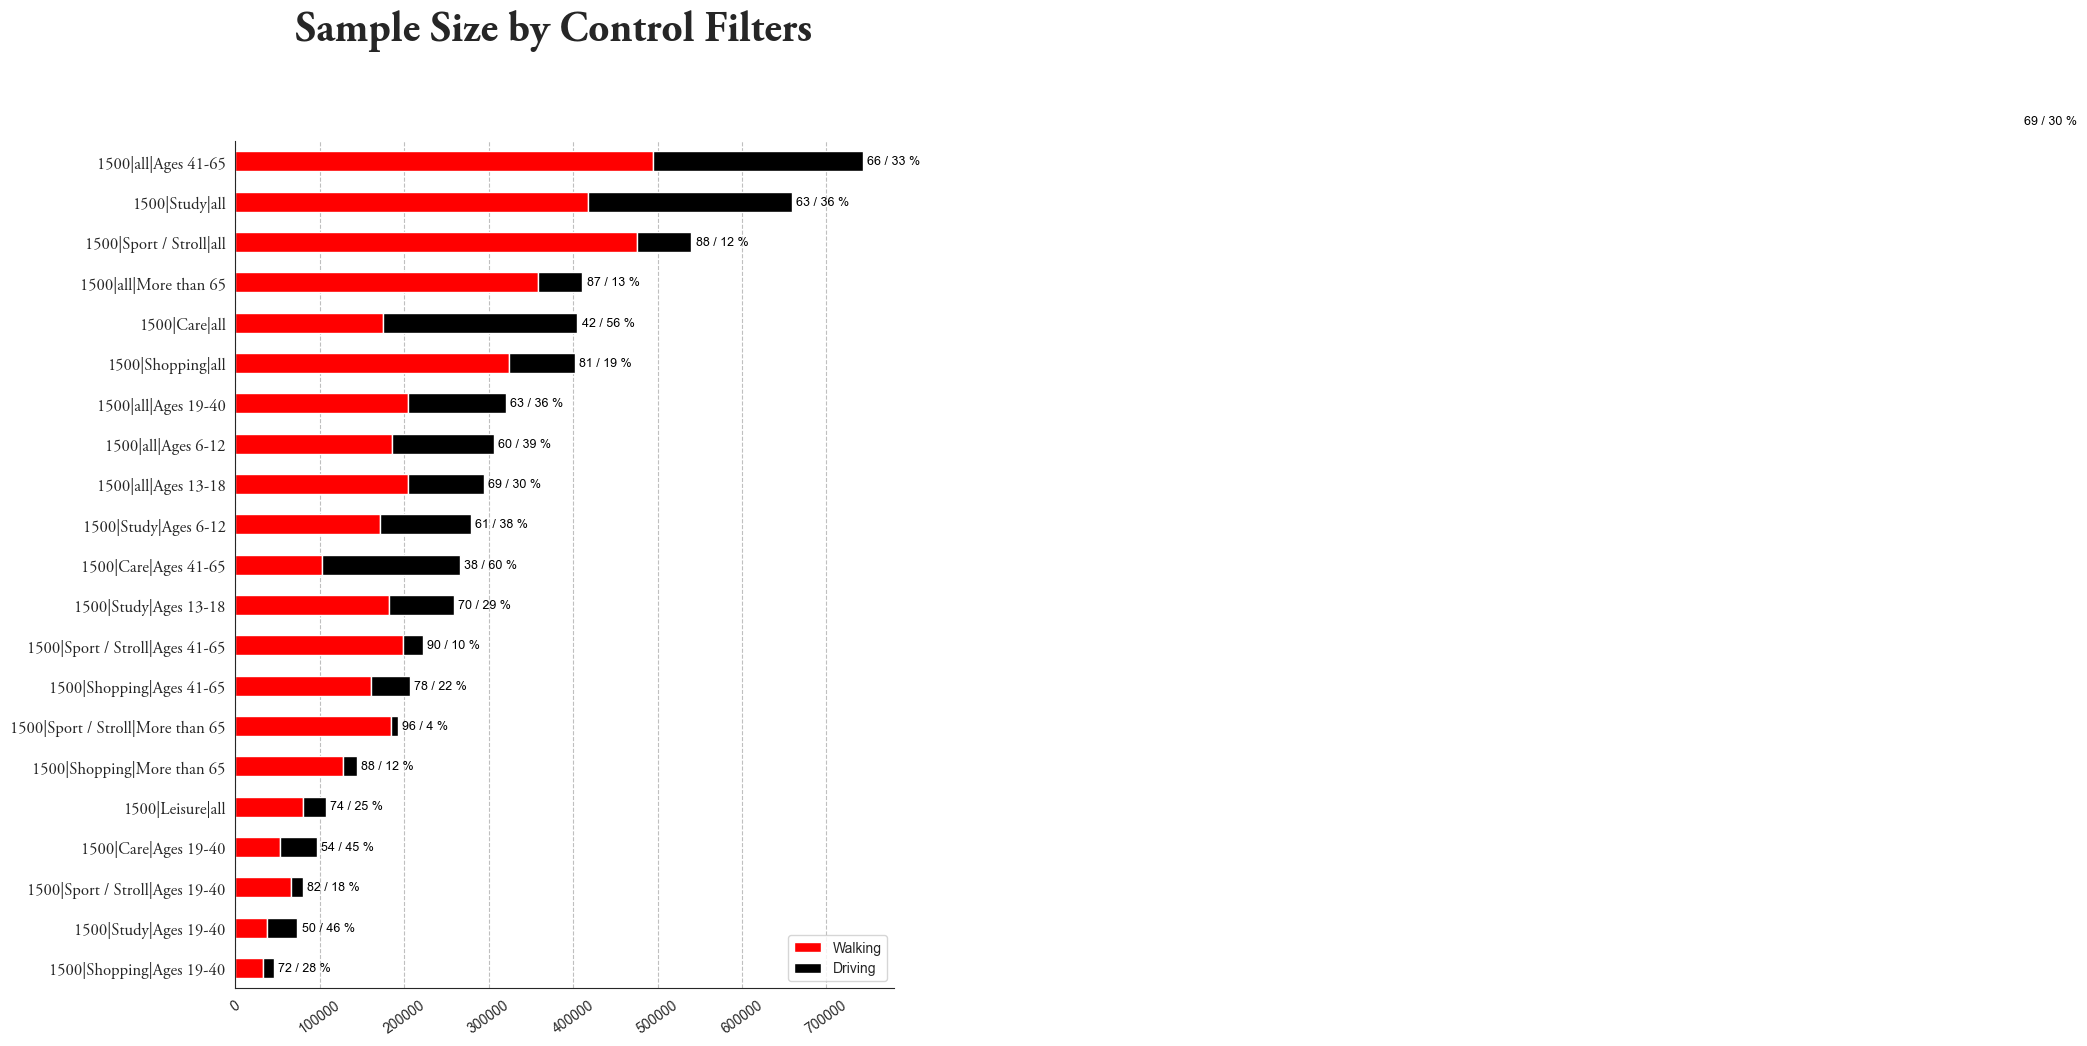

In [57]:
fig, ax = plt.subplots(figsize=(8.5, 11))
fig.suptitle('Sample Size by Control Filters', fontweight="bold", y=1, **csfont)

cr = {
    'walk_size': 'red',
    'drive_size': 'black'}

df_sorted[df_sorted.index != '1500|all|all'][['walk_size','drive_size']].rename(columns={'walk_size':"Walking",'drive_size':"Driving"}).plot(kind='barh',stacked=True,ax=ax, color=['red','black']) 


for i, (index, row) in enumerate(df_sorted[df_sorted.index != '900|all|all'].iterrows()):
    # Calculate the total length of the stacked bar
    total_length = row['walk_size'] + row['drive_size']
    
    # Create the label text in the format "{walk_perc} / {drive_perc}"
    label_text = f"{row['walk_perc']:.0f} / {row['drive_perc']:.0f} %"
    
    # Place the label at the end of the bar
    ax.text(
        x=total_length + 5000,  # Slightly offset to the right of the bar
        y=i,  # Corresponds to the bar index
        s=label_text,
        va='center',
        ha='left',
        color='black',
        fontsize=9
    )
ax.set_yticklabels(
    df_sorted[df_sorted.index != '1500|all|all'].index,  # Use the index of the DataFrame for labels
    fontdict=hfont
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', linestyle='--', color='gray', alpha=0.5) 
ax.set_ylabel('')
ax.ticklabel_format(axis='x', style='plain', useOffset=False)  # No scientific notation
plt.xticks(rotation=35)
plt.tight_layout()
#plt.savefig(r"C:\Users\katul\OneDrive\Escritorio\dataset_balance.jpg")
plt.show()


In [58]:
for dft in ('300',ds_300),('600',ds_600),('900',ds_900),('1200',ds_1200),('1500',ds_1500):
    dft[1].to_parquet(r"G:\Mi unidad\walknet_datalake\extractions\extraction_{di}.parquet".format(di = dft[0]))

In [59]:
df_sorted

,table_size,sample_size,sample_walk,sample_drive,walk_perc,drive_perc,walk_size,drive_size
index,,,,,,,,
1500|Shopping|Ages 19-40,592,45648,3.295454e+04,12693.840071,72.0,27.81,3.295454e+04,12693.840071
1500|Study|Ages 19-40,1011,76663,3.817360e+04,35420.386461,50.0,46.20,3.817360e+04,35420.386461
1500|Sport / Stroll|Ages 19-40,1083,80248,6.556093e+04,14551.370465,82.0,18.13,6.556093e+04,14551.370465
1500|Care|Ages 19-40,1338,97553,5.253269e+04,44114.838162,54.0,45.22,5.253269e+04,44114.838162
1500|Leisure|all,1497,108712,7.997611e+04,27633.307898,74.0,25.42,7.997611e+04,27633.307898
1500|Shopping|More than 65,2030,144192,1.272184e+05,16966.304161,88.0,11.77,1.272184e+05,16966.304161
1500|Sport / Stroll|More than 65,2770,192544,1.845067e+05,8038.160520,96.0,4.17,1.845067e+05,8038.160520
1500|Shopping|Ages 41-65,3017,206908,1.608645e+05,45720.831340,78.0,22.10,1.608645e+05,45720.831340
1500|Sport / Stroll|Ages 41-65,3208,222421,1.992265e+05,22967.057341,90.0,10.33,1.992265e+05,22967.057341
